## Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [18]:
import os
from keras.preprocessing.image import ImageDataGenerator

datadir = 'E:\\Xception\\imagenette2'
trainingset = datadir+'\\train\\'
testset = datadir + '\\val\\'

batch_size = 8
data_generator = ImageDataGenerator(
    rescale = 1. / 255)

train_generator = data_generator.flow_from_directory(
    directory=trainingset,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_generator = data_generator.flow_from_directory(
    directory=testset,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Image input (256, 256, 3)
Classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Loaded 9469 training samples from 10 classes.
Loaded 3925 test samples from 10 classes.


In [3]:
image_h, image_w = 256, 256
classes = sorted(['n03417042', 'n03028079', 'n03888257', 'n02102040', 'n01440764', 'n03445777', 'n03000684', 'n02979186', 'n03394916', 'n03425413'])
label_map = {v:i for i, v in enumerate(classes)}

def read_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img.set_shape([None,None,3])
  img = tf.image.resize(img, [image_w, image_h])
  img  = img/255.0
  return img

datadir = 'E:\\Xception\\imagenette2'
train_images = datadir+'\\train\\'
val_images = datadir + '\\val\\'

train_images = glob('E:\\Xception\\imagenette2\\train\\*\\*')
np.random.shuffle(train_images)
train_labels = [label_map[x.split('\\')[4]] for x in train_images]

val_images = glob('E:\\Xception\\imagenette2\\val\\*\\*')
np.random.shuffle(val_images)
val_labels = [label_map[x.split('\\')[4]] for x in val_images]

def load_data(image_path, label):
  image = read_img(image_path)
  return image, label


## Creating data generator

In [4]:
def data_generator(features,labels):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset

## Visualizing Input Images

In [8]:
def show_img(dataset):
  plt.figure(figsize=(15,15))
  for i in range(8):
    for val in dataset.take(1):
      img  = val[0][i]*255.0
      plt.subplot(4,2,i+1)
      plt.imshow(tf.cast(img,tf.uint8))
      plt.title(val[1][i].numpy())
      plt.subplots_adjust(hspace=1)
  plt.show()

train_dataset = data_generator(train_images,train_labels)
val_dataset = data_generator(val_images,val_labels)
show_img(train_dataset)


AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 1080x1080 with 0 Axes>

n03417042


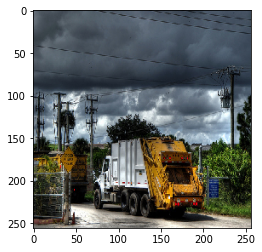

n03394916


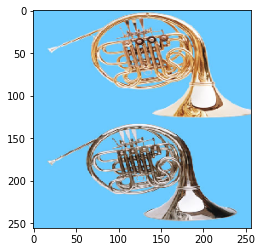

n01440764


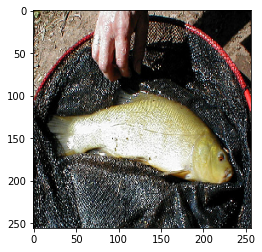

In [9]:
import matplotlib.pyplot as plt

n = 3 # number of images to show
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()
    

## Model

![picture](https://miro.medium.com/max/1400/1*hOcAEj9QzqgBXcwUzmEvSg.png)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()
    
    # entry flow
    

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

In [19]:
def block(layer,filters,kernel_size,strides=1,padding='valid',layer_name='conv',
          pool_size=2,pool_strides=None,filter_2=False):
          
  if layer_name == 'conv':
    layer = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,
                                   strides=strides,use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.Conv2D(filters=filters*2,kernel_size=kernel_size,
                                  use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
  
  elif layer_name == 'separable_conv':
    layer = tf.keras.layers.SeparableConv2D(filters, kernel_size,
                                            padding=padding, use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)    
    if filter_2:
      layer = tf.keras.layers.SeparableConv2D(filter_2, kernel_size,
                                              padding=padding, use_bias=False)(layer)
    else:
      layer = tf.keras.layers.SeparableConv2D(filters, kernel_size,
                                              padding=padding, use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.MaxPooling2D(pool_size, strides=pool_strides,
                                         padding=padding)(layer)
  return layer

def add_block(layer,filters,kernel_size,strides=1,padding='valid',pool_size=2,pool_strides=None):
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters,kernel_size,padding=padding,use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters,kernel_size,padding=padding,use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.MaxPooling2D(pool_size, strides=pool_strides,
                                         padding=padding)(layer)
  return layer  

In [20]:
def entry_flow(input_layer):	
  block_1 = block(input_layer,32,3,2,layer_name='conv')

  block_2 = block(block_1,128,3,padding='same',layer_name='separable_conv')
  layer_add = tf.keras.layers.Conv2D(filters=128,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(block_1)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_2,layer_add])

  block_3 = add_block(layer,256,3,1,'same',3,2)
  layer_add = tf.keras.layers.Conv2D(filters=256,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_3,layer_add])

  block_4 = add_block(layer,728,3,1,'same',3,2)
  layer_add = tf.keras.layers.Conv2D(filters=728,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_4,layer_add])
  return layer

In [21]:
def middle_flow(input_layer):
    for _ in range(8):
      for __ in range(3):
        layer = tf.keras.layers.ReLU()(input_layer)
        layer = tf.keras.layers.SeparableConv2D(filters=728, kernel_size=3,
                                                padding='same',use_bias=False)(layer)
        layer = tf.keras.layers.BatchNormalization()(layer)
      output_layer = tf.keras.layers.Add()([input_layer, layer])
    return output_layer

In [22]:
def exit_flow(input_layer):
  layer = tf.keras.layers.ReLU()(input_layer)
  block_1 = block(layer,728,3,padding='same',layer_name='separable_conv',
                  pool_size=3,pool_strides=2,filter_2=1024)
 
  layer_add = tf.keras.layers.Conv2D(filters=1024, kernel_size=1, 
                                 strides=2, padding='same', use_bias=False)(input_layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)                                  
  layer = tf.keras.layers.Add()([block_1, layer_add])

  layer = tf.keras.layers.SeparableConv2D(filters=1536, kernel_size=3,
                                          padding='same',use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters=2048, kernel_size=3,
                                          padding='same',use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.GlobalAvgPool2D()(layer)
  layer = tf.keras.layers.Dense(1000, activation='relu')(layer)
 
  return layer


In [23]:
def xception(shape,include_top):
  model_input = tf.keras.layers.Input(shape=shape)
  entry_block = entry_flow(model_input)
  mid_block = middle_flow(entry_block)
  exit_block = exit_flow(mid_block)

  if include_top:
    model_output = tf.keras.layers.Dense(10)(exit_block)
    model = tf.keras.models.Model(model_input, model_output)
  model = tf.keras.models.Model(model_input, model_output)
  model.summary()
  return model

shape =  input_shape
#shape =  image_w,image_h,3
model = xception(shape,include_top=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 127, 127, 32) 128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
re_lu_66 (ReLU)                 (None, 127, 127, 32) 0           batch_normalization_75[0][0]     
____________________________________________________________________________________________

In [27]:
epochs = 50
starter_learning_rate = 1e-2
end_learning_rate = 1e-5
decay_steps = 80000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.8)

model.compile(loss=tf.losses.CategoricalCrossentropy
              (from_logits=True), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate_fn), 
              metrics=[tf.metrics.CategoricalAccuracy()])


callbacks = [
    tf.keras.callbacks.ModelCheckpoint('xception_model.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model.fit(train_generator,
          epochs=epochs,steps_per_epoch=train_generator.n//train_generator.batch_size)


#model.fit(train_dataset,
#          epochs=epochs,steps_per_epoch=len(train_images)//batch_size,
#          callbacks=callbacks)


Epoch 1/50
 293/1183 [======>.......................] - ETA: 18:45 - loss: 2.0821 - categorical_accuracy: 0.2595

KeyboardInterrupt: 

## Inference

In [ ]:
plt.figure(figsize=(15,15))
for i in range(8):
  for val in val_dataset.take(1):
    plt.subplot(4,2,i+1)
    img  = (val[0][i]*255.0)
    plt.imshow(tf.cast(img,tf.uint8))
    y_pred = model.predict(np.expand_dims(val[0][i],axis=0))
    y_pred = np.argmax(y_pred,axis=1)
    plt.title('Ground Truth{}, Predicted{}'.format(val[1][i],y_pred))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()